# Prepare search engine

## Train model with CNN and Arcface

https://www.simonwenkel.com/2019/07/16/exploring-EMNIST.html#emnist-balanced

The purpose of this section is to train a Deep learning model that will create a vector representation of images of a single character.

The input shape of images is (28, 28, 1) and the output vector is 128.

The model will be composed of :
- 3 blocks composed of a Convolutional layer and a MaxPooling layer
- 1 batch Normalization layer
- 1 DropOut layer
- 1 Flatten layer
- 1 Dense layer
- 1 Arcface block

The model will be trained using ArcfaceLoss.

The Arcface block will be removed from the final model so that we get the features vector from the last flattened dense layer?

In [1]:
import numpy as np

#import tensorflow.keras.datasets.mnist as mnist
from extra_keras_datasets import emnist
from sklearn import preprocessing

from tensorflow.keras import Model
from tensorflow.keras.models import save_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    Dropout,
    Flatten,
    Dense
)

from modules.arcface import ArcFaceBlock, ArcFaceLoss

# le = preprocessing.LabelEncoder()
# trained_le = le.fit(train)
# train = trained_le.transform(train)
# test = trained_le.transform(test)

# Load dataset
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = emnist.load_data(type='letters')

# Normalize data
x_train = x_train[:, :, :, np.newaxis].astype('float32') / 255
x_test = x_test[:, :, :, np.newaxis].astype('float32') / 255

# mnist is composed of 10 classes
# emnist-letters is composed of 26 classes
NUMBER_OF_CLASSES = 26


y_train = to_categorical(y_train-1, NUMBER_OF_CLASSES) # -1 because the classes start at 0 and not 1
y_test = to_categorical(y_test-1, NUMBER_OF_CLASSES)

INFO:root:Loading dataset = emnist


In [2]:
print('Train dataset has %s images of shape %s' % (x_train.shape[0], x_train.shape[1:]))
print('Test dataset has %s images of shape %s' % (x_test.shape[0], x_test.shape[1:]))

Train dataset has 124800 images of shape (28, 28, 1)
Test dataset has 20800 images of shape (28, 28, 1)


In [3]:
val_size = int(x_train.shape[0] / 10)

y_val = y_train[-val_size:]
x_val = x_train[-val_size:]
y_train = y_train[:-val_size]
x_train = x_train[:-val_size]

In [4]:
# Create Neural Network

input_shape = (28, 28, 1)
target_tensor = (NUMBER_OF_CLASSES,)

inputs = Input(shape=input_shape)
label = Input(shape=target_tensor)

x = Conv2D(16, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(256, name='features_vector', kernel_initializer='he_normal')(x)

outputs = ArcFaceBlock(n_classes = NUMBER_OF_CLASSES)(x)
m = Model(inputs=inputs, outputs=outputs, name="mnist_arcface")

# Add ArcFace Block
ARGS = {'m':0.5, 's':32}
m.compile(
    optimizer = 'rmsprop', 
    loss = ArcFaceLoss(**ARGS),
    metrics=[CategoricalAccuracy()]
)

m.summary()

Model: "mnist_arcface"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)        

In [5]:
# Hyperparmeters
BATCH_SIZE = 1024
EPOCHS = 10

In [6]:
# Train
history = m.fit(
    x=x_train, 
    y=y_train, 
    validation_data=(x_val, y_val), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE
)

Epoch 1/10
110/110 [==============================] - 16s 138ms/step - loss: 15.5180 - categorical_accuracy: 0.5436 - val_loss: 14.8284 - val_categorical_accuracy: 0.6259
Epoch 2/10
110/110 [==============================] - 15s 134ms/step - loss: 13.2917 - categorical_accuracy: 0.6630 - val_loss: 11.8105 - val_categorical_accuracy: 0.7577
Epoch 3/10
110/110 [==============================] - 16s 141ms/step - loss: 12.5148 - categorical_accuracy: 0.6945 - val_loss: 11.0234 - val_categorical_accuracy: 0.7691
Epoch 4/10
110/110 [==============================] - 16s 145ms/step - loss: 12.0764 - categorical_accuracy: 0.7101 - val_loss: 10.0661 - val_categorical_accuracy: 0.7997
Epoch 5/10
110/110 [==============================] - 16s 145ms/step - loss: 11.7712 - categorical_accuracy: 0.7221 - val_loss: 9.5072 - val_categorical_accuracy: 0.8099
Epoch 6/10
110/110 [==============================] - 16s 141ms/step - loss: 11.5637 - categorical_accuracy: 0.7334 - val_loss: 9.3797 - val_categ

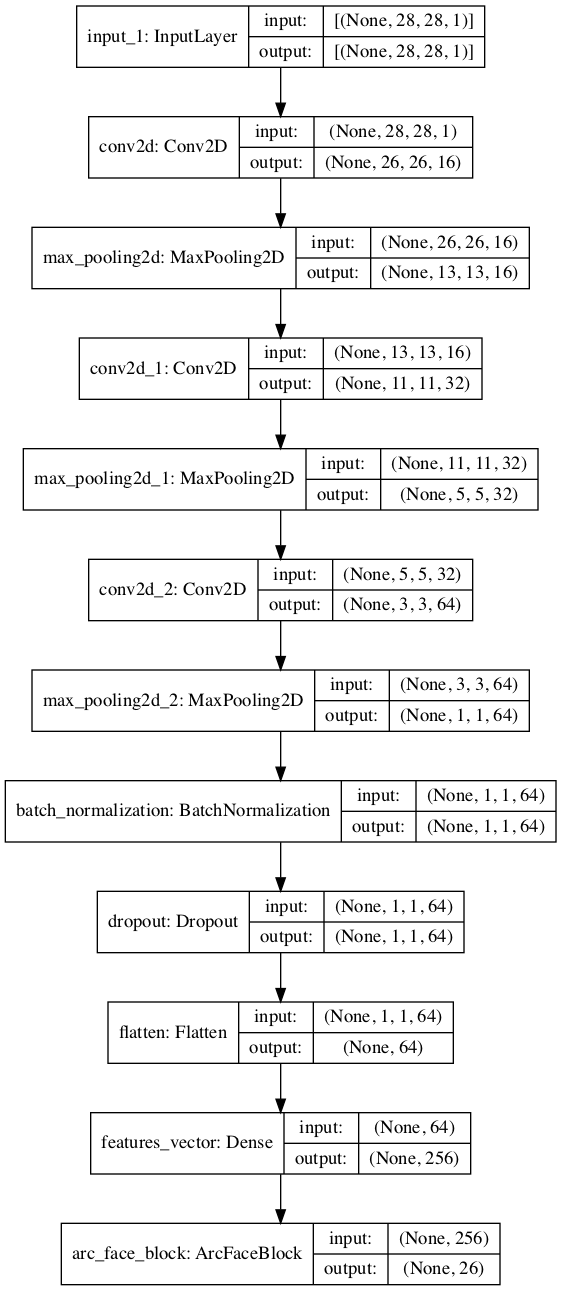

In [7]:
from tensorflow.keras.utils import plot_model
plot_model(m, to_file='arface_model.png', show_shapes=True)

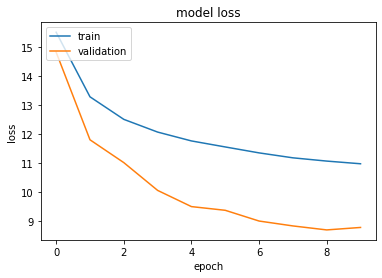

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

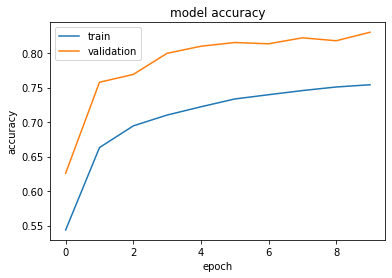

In [9]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
train_eval = m.evaluate(x_train, y_train)
val_eval = m.evaluate(x_val, y_val)
test_eval = m.evaluate(x_test, y_test)

model_accuracy = np.array([train_eval[1], val_eval[1], test_eval[1]]).min()

650/650 [==============================] - 1s 2ms/step - loss: 14.3426 - categorical_accuracy: 0.7364


In [11]:
print(f'Model Accuracy : {model_accuracy}')

Model Accuracy : 0.7364423274993896


In [12]:
# Save Base Model
m.save('../storage/models/arcface-trained-model.h5')

# Save Features extraction model (base model without arcface block)
m_prod = Model(inputs=m.inputs, outputs= m.get_layer('features_vector').output, name="mnist_arcface")

save_model(
    m_prod,
    "../storage/models/my_production_model",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

INFO:tensorflow:Assets written to: ../storage/models/my_production_model/assets


INFO:tensorflow:Assets written to: ../storage/models/my_production_model/assets


## Create a simple database of features vector

In [13]:
alphabet = [
    "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", 
    "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"
]

map_class = {cl: letter for cl, letter in enumerate(alphabet)}

In [14]:
import json

In [15]:
indices = np.random.choice(x_test.shape[0], 1500)

In [16]:
x_db = x_test[indices]
y_db = y_test[indices]

In [17]:
unique, counts = np.unique(np.argmax(y_db, axis=1), return_counts=True)
counter = dict(zip(unique, counts))

In [18]:
len(counter) == NUMBER_OF_CLASSES

True

<BarContainer object of 26 artists>

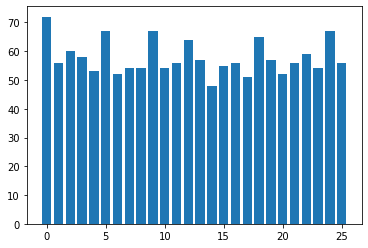

In [19]:
plt.bar(unique, counts)

In [20]:
i = 1
for img, c in zip(x_db, y_db):
    imgr = img.reshape((-1,28,28,1))
    vector = m_prod.predict(imgr)[0].tolist()
    im_class = map_class.get(np.argmax(c))
    idx = i
    point = {
        "id": idx,
        "payload": {"class": im_class},
        "vector": vector
    }
    
    with open(f"../storage/collections_resources/point_{idx}_{im_class}.json", 'w') as f:
        json.dump(point, f)
    i+=1